In [7]:
#!pip install optuna ipywidgets

In [40]:
#import dependencies
import util_supervised
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [12]:
import optuna

In [16]:
#load data
df = util_supervised.load_feature_dataset_pca()
compounds_ser = df.Metadata_Compound
train_X, train_y, test_X, test_y = util_supervised.sup_train_test_split(df)

#training and test compounds (data is split by compound)
compounds_train = compounds_ser[train_X.index]
compounds_test = compounds_ser[test_X.index]

In [14]:
#make and fit model
#However, this is not the legit model because it does not use the right cross-validation scheme. 
randomstate = 224

m_randomforest = RandomForestClassifier(random_state=randomstate)
m_randomforest.fit(train_X, train_y)
test_pred = pd.Series(m_randomforest.predict(test_X))
test_y = test_y.reset_index(drop=True)
match = sum(test_pred == test_y) 
total = len(test_pred)

print(match, "correct.", total, "total. Accuracy =", round(match/total, 3))

cv_scores = cross_val_score(m_randomforest, train_X, train_y, cv=5)
print(cv_scores)

1478 correct. 2216 total. Accuracy = 0.667
[0.42332066 0.60583016 0.58301648 0.7896071  0.89086294]


<AxesSubplot:>

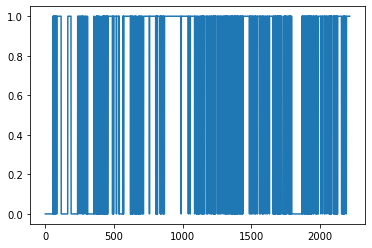

In [5]:
matches = test_pred==test_y
matches = pd.Series([int(x) for x in matches])
matches.plot()

In [21]:
train_X[compounds_train!='DMSO'].shape, train_X[compounds_train=='DMSO'].shape, train_X.shape

((2624, 256), (1320, 256), (3944, 256))

In [29]:
#Make and fit model with leave-one-out cross-validation
m_forest_loo = RandomForestClassifier(random_state=randomstate)
#m_forest_loo.fit(train_X, train_y)

def rf_loo_crossval(clf, train_X=train_X, train_y=train_y, compounds=compounds_train):
    cv_scores = []

    for c in compounds.unique():
        train_val_X = train_X[compounds_train!=c]
        train_val_y = train_y[compounds_train!=c]
        train_test_X = train_X[compounds_train==c]
        train_test_y = train_y[compounds_train==c]
        clf.fit(train_val_X, train_val_y)
        score = round(clf.score(train_test_X, train_test_y), 2)
        #print(c, score)
        cv_scores.append(score)
        weighted_accuracy = np.mean(cv_scores)
    return weighted_accuracy

In [30]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=randomstate)
dummy_cv_scores = rf_loo_crossval(dummy_clf)
dummy_cv_scores

0.07551724137931036

In [31]:
loo_cv_scores = rf_loo_crossval(m_forest_loo)

In [25]:
loo_cv_scores, dummy_cv_scores
#okay, default is 3.5x better than dummy, look like its working!

(0.2420689655172414, 0.07551724137931036)

In [25]:
##Optimize random forest model

def objective(trial, randomstate=randomstate, X_train=train_X,
             y_train=train_y, X_test=test_X, y_test=test_y):
    #I already have xtrain ytrain etc
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    # Create the model with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=randomstate
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    y_test = y_test.reset_index(drop=True)
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy
    match = sum(y_pred == y_test) 
    total = len(y_test)

    accuracy = round(match/total, 3)
    
    accuracy = rf_loo_crossval(m_forest_loo)
    return accuracy
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-06-24 14:01:09,873] A new study created in memory with name: no-name-38069d76-08b3-4549-b069-9335266c116e
[I 2024-06-24 14:01:13,028] Trial 0 finished with value: 0.677 and parameters: {'n_estimators': 90, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.677.
[I 2024-06-24 14:01:16,630] Trial 1 finished with value: 0.609 and parameters: {'n_estimators': 191, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.677.
[I 2024-06-24 14:01:19,897] Trial 2 finished with value: 0.658 and parameters: {'n_estimators': 117, 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.677.
[I 2024-06-24 14:01:19,994] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 20, 'max_depth': 1, 'min_samples_split': 16, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.677.
[I 2024-06-24 14:01:22,040] Trial 4 finished with value: 0.637 and parameters: {'n_

[I 2024-06-24 14:04:39,936] Trial 40 finished with value: 0.671 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 7}. Best is trial 28 with value: 0.703.
[I 2024-06-24 14:04:45,064] Trial 41 finished with value: 0.694 and parameters: {'n_estimators': 126, 'max_depth': 27, 'min_samples_split': 17, 'min_samples_leaf': 2}. Best is trial 28 with value: 0.703.
[I 2024-06-24 14:04:50,683] Trial 42 finished with value: 0.699 and parameters: {'n_estimators': 138, 'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 2}. Best is trial 28 with value: 0.703.
[I 2024-06-24 14:04:57,459] Trial 43 finished with value: 0.68 and parameters: {'n_estimators': 178, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 4}. Best is trial 28 with value: 0.703.
[I 2024-06-24 14:05:05,062] Trial 44 finished with value: 0.695 and parameters: {'n_estimators': 188, 'max_depth': 24, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 28 

[I 2024-06-24 14:08:39,643] Trial 81 finished with value: 0.682 and parameters: {'n_estimators': 164, 'max_depth': 31, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 77 with value: 0.708.
[I 2024-06-24 14:08:46,438] Trial 82 finished with value: 0.689 and parameters: {'n_estimators': 177, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 77 with value: 0.708.
[I 2024-06-24 14:08:54,187] Trial 83 finished with value: 0.696 and parameters: {'n_estimators': 191, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 2}. Best is trial 77 with value: 0.708.
[I 2024-06-24 14:09:00,897] Trial 84 finished with value: 0.676 and parameters: {'n_estimators': 182, 'max_depth': 29, 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 77 with value: 0.708.
[I 2024-06-24 14:09:01,376] Trial 85 finished with value: 0.609 and parameters: {'n_estimators': 12, 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 77 

In [26]:
study.best_params, study.best_value

({'n_estimators': 157,
  'max_depth': 25,
  'min_samples_split': 15,
  'min_samples_leaf': 4},
 0.708)

In [41]:
m_finalforest = RandomForestClassifier(random_state=randomstate,
                                       n_estimators=157,
                                       max_depth=25,
                                       min_samples_split=15,
                                       min_samples_leaf=4)


m_randomforest.fit(train_X, train_y)
test_pred = pd.Series(m_randomforest.predict(test_X))
test_y = test_y.reset_index(drop=True)
match = sum(test_pred == test_y) 
total = len(test_pred)

<AxesSubplot:>

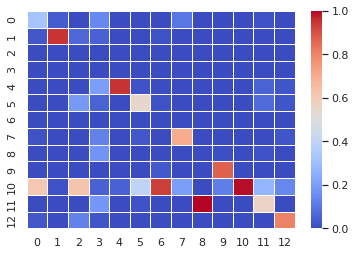

In [45]:
#draw random forest confusion matrix
cm = confusion_matrix(test_y, test_pred, normalize = 'pred')
sns.heatmap(cm, cmap = "coolwarm", linewidths=.7, linecolor='white')

<AxesSubplot:>

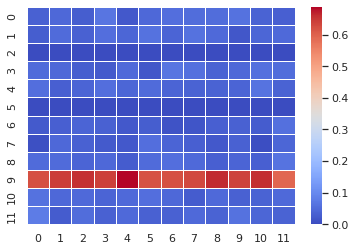

In [49]:
#draw confusion matrix for dummy classifier
test_pred_dumb = dummy_clf.predict(test_X)
cm = confusion_matrix(test_y, test_pred_dumb, normalize = 'pred')
sns.heatmap(cm, cmap = "coolwarm", linewidths=.7, linecolor='white')